In [1]:
import graphein
graphein.verbose(enabled=False)
import warnings
warnings.filterwarnings("ignore")
from graphein.ml import GraphFormatConvertor
import torch
import lightning
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.utils import to_networkx
from graphein.protein.visualisation import plotly_protein_structure_graph

Don't forget to use your `load_graph` function from the previous notebook:

In [2]:
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.features.nodes import amino_acid as graphein_nodes
from graphein.protein import edges as graphein_edges
from graphein.protein.subgraphs import extract_subgraph
from functools import partial

def load_graph(pdb_id, chain):
    graph_config = ProteinGraphConfig(
        node_metadata_functions = [graphein_nodes.amino_acid_one_hot, graphein_nodes.meiler_embedding],
        edge_construction_functions = [graphein_edges.add_peptide_bonds, 
                                       partial(graphein_edges.add_distance_threshold, 
                                               threshold=8.,
                                               long_interaction_threshold=2)],
    )
    graph = construct_graph(pdb_code=pdb_id, config=graph_config, verbose=False)
    interface_residues = set()
    for source, target, kind in graph.edges(data=True):
        c1, c2 = source.split(":")[0], target.split(":")[0]
        if 'distance_threshold' in kind['kind']:
            if c1 == chain and c2 != chain:
                interface_residues.add(source)
            elif c2 == chain and c1 != chain:
                interface_residues.add(target)
    graph = extract_subgraph(graph, chains=chain)
    for node, data in graph.nodes(data=True):
        if node in interface_residues:
            data['interface_label'] = 1
        else:
            data['interface_label'] = 0
    return graph

## Converting graphs to deep learning datasets

Deep learning libraries like PyTorch, and by extension PyTorch-Geometric, have some standardized ways of handling data and datasets, in order to optimize the operations they perform on the various numeric features involved. In this notebook, we will see how to convert a graph into a torch `Data` object, which is the standard way of representing a graph in PyTorch-Geometric. Then we'll go from a single graph to a `Dataset` of graphs, which is the standard way of representing a dataset in PyTorch. And finally, we'll see how to wrap this `Dataset` into a Lightning `DataModule`, which is the standard way of handling data-related operations in PyTorch-Lightning.

### Data 

We first need to make a torch `Data` object from our graphs. This is easily done with graphein's conversion functions, specifically the `GraphFormatConvertor`, where you can specify which features of the NetworkX graph you'd like to retain in the `Data` object.

In [47]:
columns = [
            "chain_id",
            "coords",
            "edge_index",
            "node_id",
            "residue_number",
            "amino_acid_one_hot",
            "meiler",
            "interface_label"
]
convertor = GraphFormatConvertor(src_format="nx", # From NetworkX 
                                 dst_format="pyg", # To PyTorch Geometric
                                 columns=columns, # The columns to be used
                                 verbose=None)
graphein_graph = load_graph("1A0G", "A")
torch_data = convertor(graphein_graph)

In [48]:
torch_data

Data(edge_index=[2, 2746], node_id=[280], chain_id=[280], residue_number=[280], coords=[280, 3], amino_acid_one_hot=[280, 20], meiler=[280, 7], interface_label=[280], num_nodes=280)

In [49]:
list(zip(torch_data.node_id[:5], torch_data.interface_label[:5]))

[('A:PRO:109', tensor(0)),
 ('A:LYS:270', tensor(0)),
 ('A:ILE:111', tensor(0)),
 ('A:GLY:262', tensor(0)),
 ('A:ASN:124', tensor(0))]

In [50]:
torch_data.edge_index.T[:5]

tensor([[  0,   2],
        [  0,   6],
        [  0,  23],
        [  0,  70],
        [  0, 107]])

For example, here are the amino acid types across interface and non-interface residues:

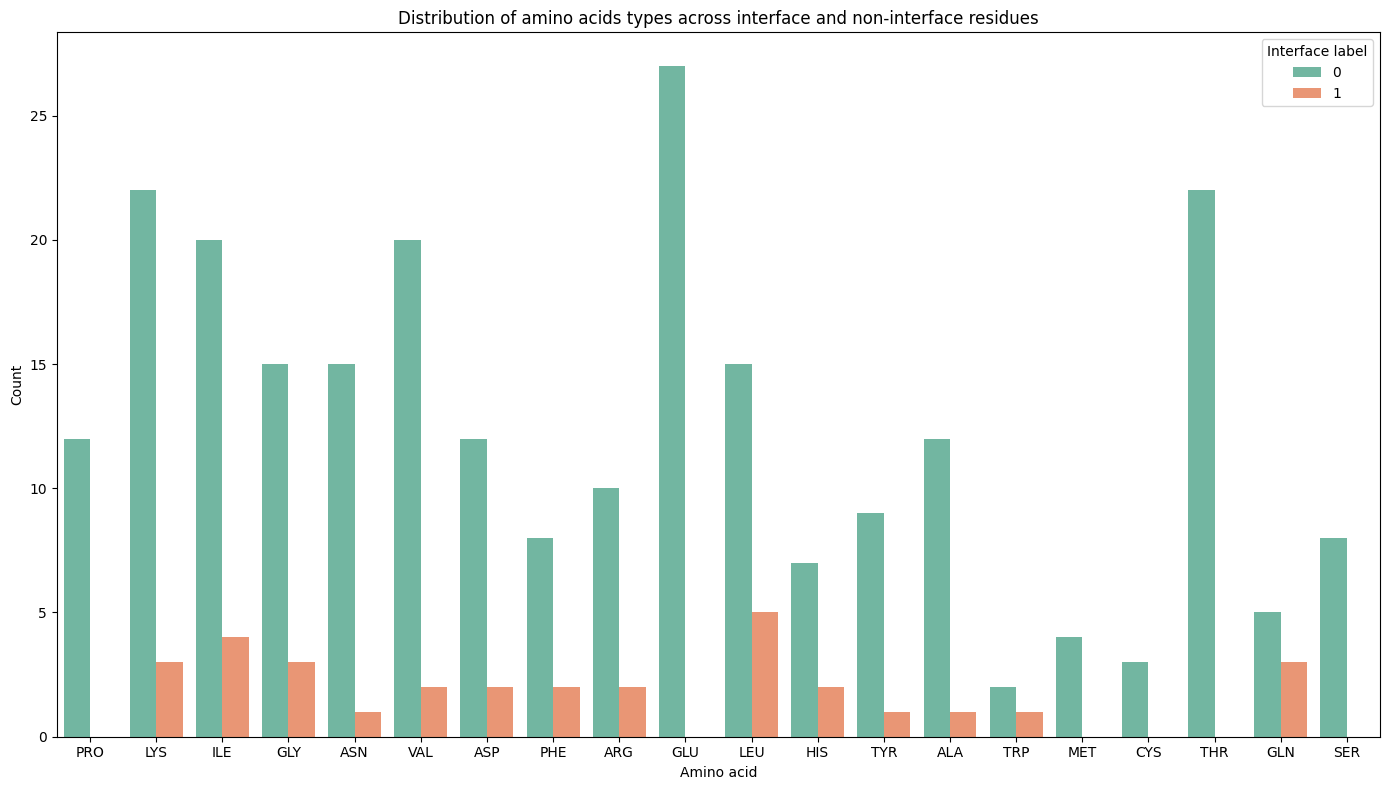

In [7]:
extracted_amino_acids = [s.split(":")[1] for s in torch_data.node_id]

data_with_aa = {"amino acid": extracted_amino_acids, "interface labels": torch_data.interface_label}

plt.figure(figsize=(14, 8))
sns.countplot(x="amino acid", hue="interface labels", data=data_with_aa, palette="Set2")
plt.title("Distribution of amino acids types across interface and non-interface residues")
plt.ylabel("Count")
plt.xlabel("Amino acid")
plt.legend(title="Interface label", loc='upper right')
plt.tight_layout()
plt.show()

We can use the `to_networkx` function to convert the `Data` object back to a NetworkX graph

In [52]:
graphein_graph_again = to_networkx(torch_data, 
                                   node_attrs=["chain_id",
                                               "coords",
                                               "node_id",
                                               "residue_number",
                                               "amino_acid_one_hot",
                                               "meiler",
                                               "interface_label"],
                                    to_undirected=True)

In [60]:
p = plotly_protein_structure_graph(
    graphein_graph_again,
    colour_edges_by=None,
    colour_nodes_by='interface_label',
    label_node_ids=False,
    plot_title="Peptide backbone graph with distance connections. Nodes coloured by interface labels.",
    node_size_multiplier=1
    )
p.show()

### Dataset

The `torch_geometric.data.Dataset` class is a standard way of representing a graph dataset in PyTorch. It is an abstract class that you can subclass to create your own dataset. The functions that need to be included are:

- `download()`: this downloads the dataset (in our case from `dataset.txt`) and saves each data point (in our case as a pickle file containing the graphein graph that our `load_graph` function returns) in `self.raw_dir`.
- `process()`: this processes the data from `self.raw_dir` to torch-geometric `Data` objects (as we did above), and saves them as `.pt` files in `self.processed_dir`.
- property functions: `raw_file_names`, `processed_file_names` return the names of the raw pickle and processed pt files for each data point.
- `len()`: this returns the number of graphs in the dataset
- `get()`: this returns the `Data` object for a given index

See the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Dataset.html#torch_geometric.data.Dataset) for more.

In [8]:
class ProteinDataset(Dataset):
    """
    torch-geometric Dataset class for loading protein files as graphs.
    """
    def __init__(self, root,
                 protein_names: list):
        columns = [
            "chain_id",
            "coords",
            "edge_index",
            "kind",
            "node_id",
            "residue_number",
            "amino_acid_one_hot",
            "meiler",
            "interface_label",
        ]
        self.convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg", columns=columns, verbose=None)
        self.protein_names = protein_names
        super(ProteinDataset, self).__init__(root)

    def download(self):
        for protein_name in self.protein_names:
            output = Path(self.raw_dir) / f'{protein_name}.pkl'
            if not output.exists():
                pdb_id, chain = protein_name.split("_")
                graphein_graph = load_graph(pdb_id, chain)
                with open(output, "wb") as f:
                    pickle.dump(graphein_graph, f)

    @property
    def raw_file_names(self):
        return [Path(self.raw_dir) / f"{protein_name}.pkl" for protein_name in self.protein_names if (Path(self.raw_dir) / f"{protein_name}.pt").exists()]

    @property
    def processed_file_names(self):
        return [Path(self.processed_dir) / f"{protein_name}.pt" for protein_name in self.protein_names if (Path(self.processed_dir) / f"{protein_name}.pt").exists()]

    def process(self):
        for protein_name in self.protein_names:
            output = Path(self.processed_dir) / f'{protein_name}.pt'
            if not output.exists():
                with open(Path(self.raw_dir) / f"{protein_name}.pkl", "rb") as f:
                    graphein_graph = pickle.load(f)
                torch_data = self.convertor(graphein_graph)
                torch.save(torch_data, output)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(self.processed_file_names[idx])
        return data


Let's make our dataset! We run it for the first 20 proteins to save time

In [9]:
with open('dataset.txt') as f:
    protein_names = [line.strip() for line in f]

dataset = ProteinDataset(root='./test_data', protein_names=protein_names[:20])


Processing...
Done!


In [10]:
dataset

ProteinDataset(20)

In [11]:
dataset[0]

Data(edge_index=[2, 2754], node_id=[282], chain_id=[282], residue_number=[282], coords=[282, 3], amino_acid_one_hot=[282, 20], meiler=[282, 7], interface_label=[282], kind=[1377], num_nodes=282)

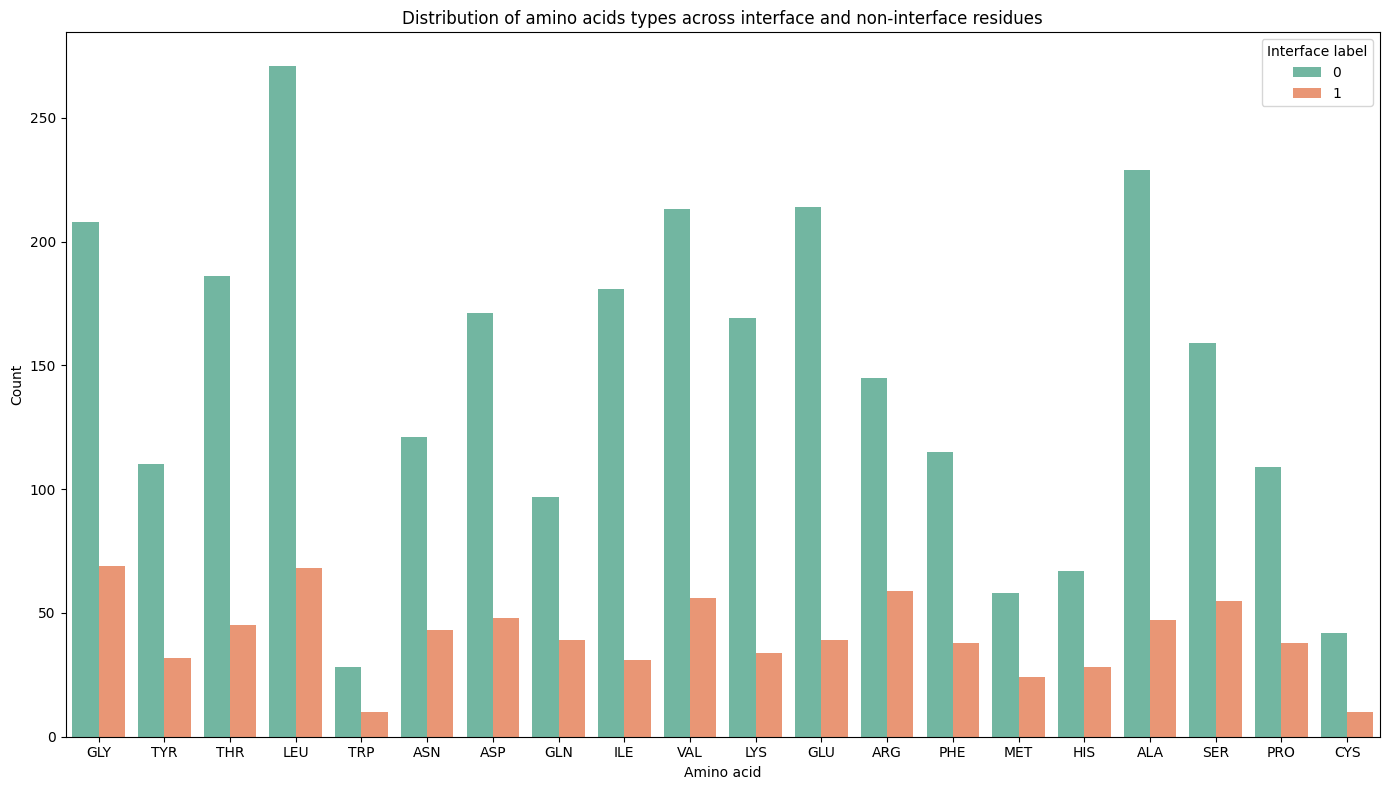

In [12]:
all_amino_acids = []
all_interface_labels = []

for torch_graph in dataset:
    extracted_amino_acids = [s.split(":")[1] for s in torch_graph.node_id]
    all_amino_acids.extend(extracted_amino_acids)
    all_interface_labels.extend(torch_graph.interface_label.tolist())

data_with_aa = {
    "amino acid": all_amino_acids,
    "interface labels": all_interface_labels
}

plt.figure(figsize=(14, 8))
sns.countplot(x="amino acid", hue="interface labels", data=data_with_aa, palette="Set2")
plt.title("Distribution of amino acids types across interface and non-interface residues")
plt.ylabel("Count")
plt.xlabel("Amino acid")
plt.legend(title="Interface label", loc='upper right')
plt.tight_layout()
plt.show()

Graphein also has a built-in `ProteinGraphDataset` class that combines these steps. It also has some nice features like 
- the ability to load a dataset of proteins from both the PDB or AlphaFold Database directory of PDB files
- the ability to apply custom transformations from your bioinformatics tools of choice to the PDB files (with the `pdb_transform` argument).

### DataModule

Now that we have our `Dataset` ready, we need to specificy how the `Data` objects within the created Dataset are split into training, validation and test sets. This is where PyTorch Lightning's DataModule comes in ([documentation](https://lightning.ai/docs/pytorch/stable/data/datamodule.html)). The `DataModule` is a class that encapsulates the logic for loading, batching and splitting the data. It's a way of separating the logic for data loading and batching separate from both the data ingestion and the model and training logic, which makes the code more modular and easier to maintain. It also makes it easier to switch between different datasets and data loading strategies.

To define a `DataModule` the following methods are necessary:
- `prepare_data()` - this defines the downloading and IO operations that are generally slower and need to only be run once. In our case it just runs the Dataset function once to download and process all the pickle and pt files. This is called once in the beginning of training so all the future calls of Dataset in setup (which is called on every node/process) just loads the data from the saved files.
- `setup()` - this defines how to split the dataset. It also takes a `stage` argument (one of `fit,validate,test,predict`).
- `train_dataloader()` - this returns the `DataLoader` for the training data

and the following are optional:
- `val_dataloader()` - this returns the `DataLoader` for the validation data
- `test_dataloader()` - this returns the `DataLoader` for the test data
- `predict_dataloader()` - this returns the `DataLoader` for the inference data

In [17]:
class ProteinGraphDataModule(lightning.LightningDataModule):
    def __init__(self, root, dataset_file, batch_size=8):
        super().__init__()
        self.root = root
        self.dataset_file = dataset_file
        with open(dataset_file) as f:
            self.protein_names = [line.strip() for line in f]
        self.protein_names = self.protein_names[:20] # SMALL DATASET FOR TESTING
        self.batch_size = batch_size

    def prepare_data(self):
        ProteinDataset(root=self.root, protein_names=self.protein_names)
    
    def setup(self, stage):
        dataset = ProteinDataset(root=self.root, protein_names=self.protein_names)
        # Here we just do a random split of 80/10/10 for train/val/test
        train_idx, val_idx, test_idx = random_split(range(len(dataset)), [0.8, 0.1, 0.1])
        self.train, self.val, self.test = dataset[list(train_idx)], dataset[list(val_idx)], dataset[list(test_idx)]

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)

The `DataModule` is now ready, give it a try and loop through the dataloader to see how they work!

In [18]:
datamodule = ProteinGraphDataModule("./test_data", "dataset.txt")
datamodule.prepare_data()
datamodule.setup("fit")

train_loader = datamodule.train_dataloader()
example_train_protein = datamodule.train[0]
example_train_batch = next(iter(train_loader))

Processing...
Done!
Processing...
Done!


We have an example train data point (`example_train_protein`) but training is almost always done on batches of data points controlled by the `batch_size`. This batch size defines the number of input graphs looked at in each iteration of the training process (one forward and backward pass). It has a trade-off between the speed of the training and the generalizability of the model.

In the graph neural network setting, a batch essentially combines all the graphs of the individual proteins into a bigger graph, with an additional batch attribute that specifies which protein each node belongs to. Since there are no edges between the different proteins, training on this batch graph is equivalent to training on the individual graphs separately, since no information flows between the different proteins. This is what is returned by the `train_dataloader` of the `DataModule`, in `example_train_batch`. 

Let's check what each of variables contain.

In [19]:
example_train_protein

Data(edge_index=[2, 844], node_id=[90], chain_id=[90], residue_number=[90], coords=[90, 3], amino_acid_one_hot=[90, 20], meiler=[90, 7], interface_label=[90], kind=[422], num_nodes=90)

In [64]:
example_train_batch

DataBatch(edge_index=[2, 14560], node_id=[8], chain_id=[8], residue_number=[1498], coords=[1498, 3], amino_acid_one_hot=[1498, 20], meiler=[1498, 7], interface_label=[1498], kind=[8], num_nodes=1498, batch=[1498], ptr=[9])

Move the `load_graph`, `ProteinDataset` and `ProteinGraphDataModule` functions and classes to `src/dataloader.py` so that we can use them in the next notebooks.